# Fake New Dectection_Dataset1

In [1]:
import numpy as np
import pandas as pd
import re,string,unicodedata
import os

# NLP Libs
import nltk
from nltk.corpus import stopwords
#from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
#from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#ML Algos
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             matthews_corrcoef,
                             cohen_kappa_score,
                             roc_auc_score)

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
# Import our data

df=pd.read_csv('./dataset/fake-news-kaggleTrump/train.csv')

# Data Analysis

In [4]:
print(df.shape)

(20800, 5)


In [5]:
df.columns

Index(['id', 'title', 'author', 'text', 'label'], dtype='object')

In [6]:
print(df.isnull().sum())


id           0
title      558
author    1957
text        39
label        0
dtype: int64


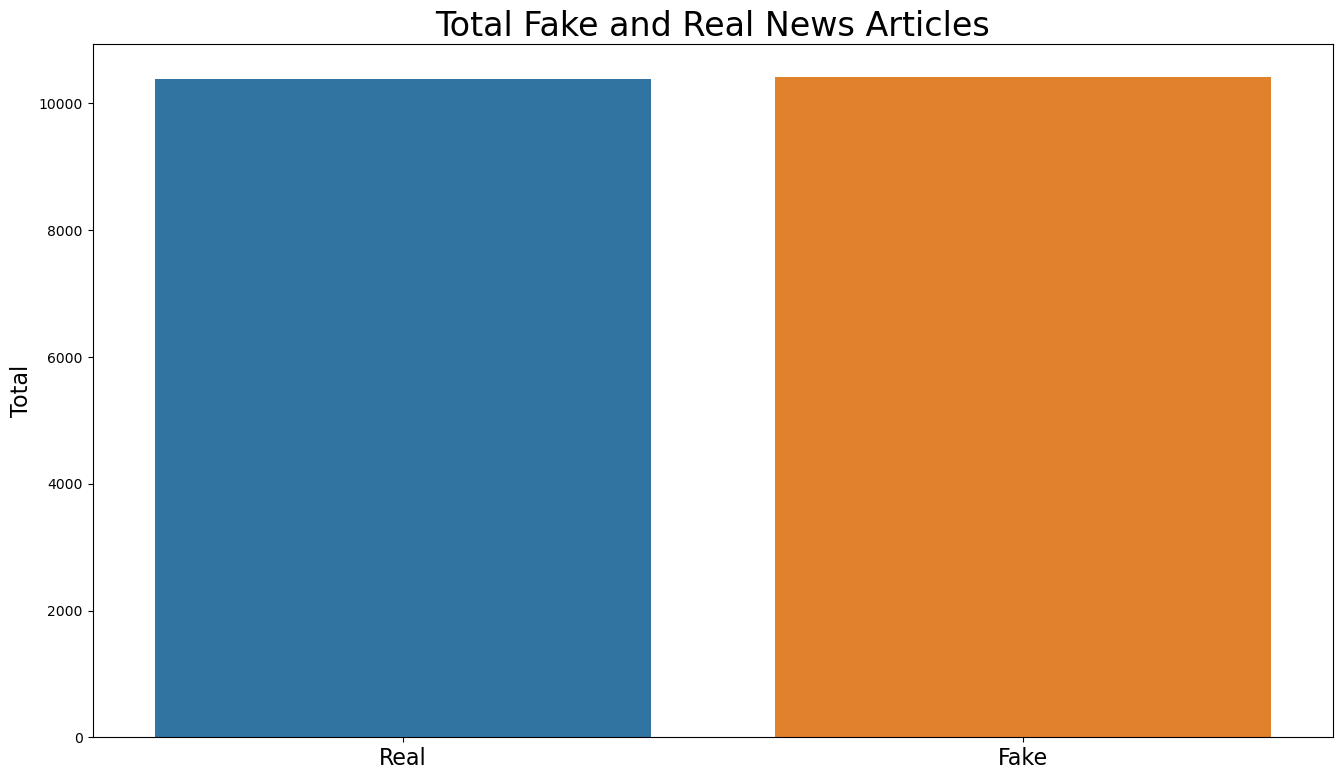

In [7]:
# Visualization Libs
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16,9))

#sns.countplot(df.label)
sns.countplot(data=df, x='label')

plt.title('Total Fake and Real News Articles', fontsize=24)
plt.ylabel('Total', fontsize=16)
plt.xlabel('')
plt.xticks([1, 0], ['Fake', 'Real'], fontsize=16)

plt.show()

In [8]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [9]:
df=df.fillna(' ')

df['total']=df['title']+' '+df['author']+' '+df['text']

In [10]:
df.head()

,id,title,author,text,label,total
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired Consortiumne...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,15 Civilians Killed In Single US Airstrike Hav...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Iranian woman jailed for fictional unpublished...


In [11]:
df = df.drop(['id','title','author','text'],axis = 1)

In [12]:
df.head()

,label,total
0,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,1,Why the Truth Might Get You Fired Consortiumne...
3,1,15 Civilians Killed In Single US Airstrike Hav...
4,1,Iranian woman jailed for fictional unpublished...


# Cleaning and preprocessing

In [13]:
#import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('omw-1.4')

In [14]:
stop_words = stopwords.words('english')
lemmatizer=WordNetLemmatizer()
for index,row in df.iterrows():
    filter_sentence = ''

    sentence = row['total']
    sentence = re.sub(r'[^\w\s]','',sentence) #cleaning
    words = nltk.word_tokenize(sentence) #tokenization
    words = [w.lower() for w in words if not w in stop_words]  #stopwords removal

    for word in words:
        filter_sentence = filter_sentence + ' ' + str(lemmatizer.lemmatize(word)).lower()

    df.loc[index,'total'] = filter_sentence

In [15]:
df.head()

,label,total
0,1,house dem aide we didnt even see comeys lette...
1,0,flynn hillary clinton big woman campus breitb...
2,1,why truth might get you fired consortiumnewsc...
3,1,15 civilian killed in single u airstrike have...
4,1,iranian woman jailed fictional unpublished st...


In [16]:
#df.to_csv("./dataset/fake-news-kaggleTrump/cleaned_dataset.csv")

# Vectorization

In [38]:
X_train = df['total']
Y_train = df['label']

In [53]:
#Feature extraction using count vectorization and tfidf.
#count_vectorizer = CountVectorizer()
#count_vectorizer.fit_transform(X_train)
#freq_term_matrix = count_vectorizer.transform(X_train)
#tfidf = TfidfTransformer(norm="l2")
#tfidf.fit(freq_term_matrix)
#tf_idf_matrix = tfidf.fit_transform(freq_term_matrix)

# CountVectorizer
count_vectorizer = CountVectorizer()
freq_term_matrix = count_vectorizer.fit_transform(X_train)

# TF-IDF Transformation
tfidf = TfidfTransformer(norm="l2")
tf_idf_matrix = tfidf.fit_transform(freq_term_matrix)

In [54]:
tf_idf_matrix

<20800x202501 sparse matrix of type '<class 'numpy.float64'>'
	with 5898836 stored elements in Compressed Sparse Row format>

# Modeling

In [55]:
test_counts = count_vectorizer.transform(df['total'].values)
test_tfidf = tfidf.transform(test_counts)

#split in samples
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(tf_idf_matrix, Y_train, random_state=0)


from sklearn.model_selection import StratifiedShuffleSplit

# Sample data (replace this with your dataset)
X = tf_idf_matrix  # Features
y = Y_train    # Target labels (0 or 1)

# Create an instance of StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

# Perform the split
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

# Now, X_train and y_train contain the training data and labels, and X_test and y_test contain the test data and labelss

In [56]:
print(X_train.shape, X_test.shape)

(16640, 202501) (4160, 202501)


In [57]:
print(y_train.shape, y_test.shape)

(16640,) (4160,)


In [58]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Training and Evaluation

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.98
Model Precison:  0.9768897448242657
Model Recall Score:  0.9740758521363418
Model F1 Score:  0.9754807692307691
Model Accuracy Score:  0.9754807692307692
classification_report: 
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      2077
           1       0.98      0.97      0.98      2083

    accuracy                           0.98      4160
   macro avg       0.98      0.98      0.98      4160
weighted avg       0.98      0.98      0.98      4160



C:\Users\Dac\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


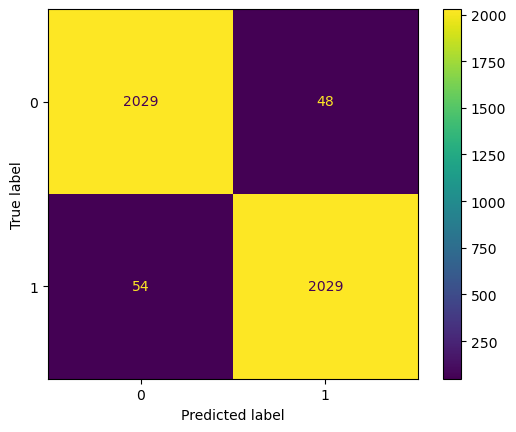

In [59]:
# DEMO
#from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e5)
logreg.fit(X_train, y_train)
pred = logreg.predict(X_test)
print('Accuracy of Logistic classifier on training set: {:.2f}'.format(logreg.score(X_train, y_train)))
print('Accuracy of Logistic classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
print('====================================')
print('Model Precison: ', precision_score(y_test, pred))
print('Model Recall Score: ', recall_score(y_test, pred))
print('Model F1 Score: ', f1_score(y_test, pred))
print('Model Accuracy Score: ', accuracy_score(y_test, pred))
print('====================================')
print('classification_report: ')
print(classification_report(y_test, pred))
cm = confusion_matrix(y_test, pred)
cm
ConfusionMatrixDisplay.from_predictions(y_test,pred)

In [60]:
def get_evaluation_result(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    mcc = matthews_corrcoef(y_test, pred)
    kappa = cohen_kappa_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred)
    
    print('Accuracy of Logistic classifier on training set: {:.2f}'.format(logreg.score(X_train, y_train)))
    print('Accuracy of Logistic classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
    print('====================================')
    # Print the results
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Matthews Correlation Coefficient: {mcc}")
    print(f"Cohen's Kappa: {kappa}")
    print(f"AUC-ROC: {roc_auc}")
    print('====================================')
    print('classification_report: ')
    print(classification_report(y_test, pred))
    cm = confusion_matrix(y_test, pred)
    cm
    ConfusionMatrixDisplay.from_predictions(y_test,pred)
    return model

# 1. “lbfgs” Logistic Regression

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.98
Accuracy: 0.9627403846153846
Precision: 0.9599236641221374
Recall: 0.9659145463274124
F1 Score: 0.96290978703039
Matthews Correlation Coefficient: 0.9254980191658101
Cohen's Kappa: 0.9254799424549829
AUC-ROC: 0.9627357998849387
classification_report: 
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      2077
           1       0.96      0.97      0.96      2083

    accuracy                           0.96      4160
   macro avg       0.96      0.96      0.96      4160
weighted avg       0.96      0.96      0.96      4160



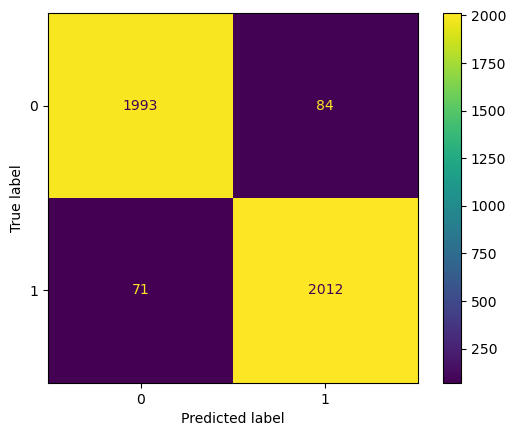

In [61]:
from sklearn.linear_model import LogisticRegression
lbfgs = LogisticRegression(solver='lbfgs')

LGFG = get_evaluation_result(lbfgs, X_train, X_test, y_train, y_test)

In [62]:
LGFG

LogisticRegression()

# 2. “liblinear” Logistic Regression

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.98
Accuracy: 0.9627403846153846
Precision: 0.9599236641221374
Recall: 0.9659145463274124
F1 Score: 0.96290978703039
Matthews Correlation Coefficient: 0.9254980191658101
Cohen's Kappa: 0.9254799424549829
AUC-ROC: 0.9627357998849387
classification_report: 
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      2077
           1       0.96      0.97      0.96      2083

    accuracy                           0.96      4160
   macro avg       0.96      0.96      0.96      4160
weighted avg       0.96      0.96      0.96      4160



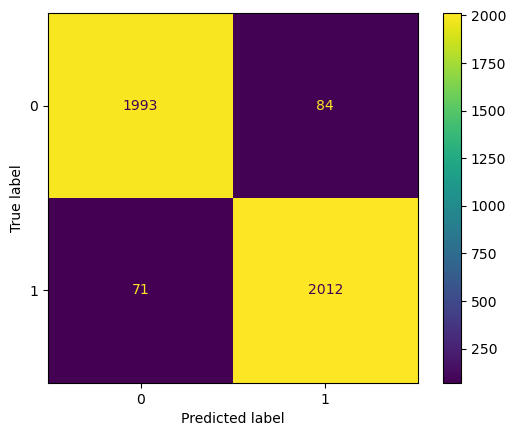

In [63]:
liblinear = LogisticRegression(solver='liblinear')

LIBLINEAR = get_evaluation_result(liblinear, X_train, X_test, y_train, y_test)

In [64]:
LIBLINEAR

LogisticRegression(solver='liblinear')

# 3. “newton-cg” Logistic Regression

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.98
Accuracy: 0.9627403846153846
Precision: 0.9599236641221374
Recall: 0.9659145463274124
F1 Score: 0.96290978703039
Matthews Correlation Coefficient: 0.9254980191658101
Cohen's Kappa: 0.9254799424549829
AUC-ROC: 0.9627357998849387
classification_report: 
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      2077
           1       0.96      0.97      0.96      2083

    accuracy                           0.96      4160
   macro avg       0.96      0.96      0.96      4160
weighted avg       0.96      0.96      0.96      4160



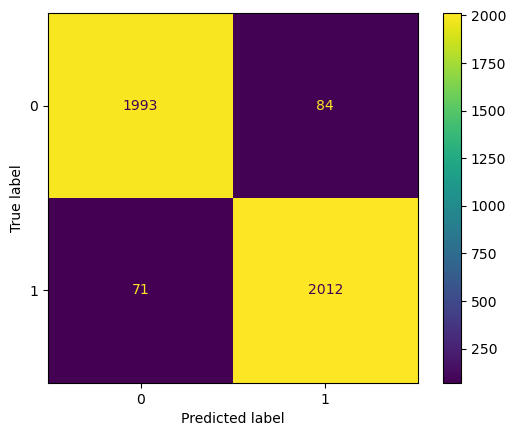

In [68]:
newton_cg = LogisticRegression(solver='newton-cg')

NEWTON = get_evaluation_result(newton_cg, X_train, X_test, y_train, y_test)

In [69]:
NEWTON

LogisticRegression(solver='newton-cg')

# 4. “sag” Logistic Regression

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.98
Accuracy: 0.9627403846153846
Precision: 0.9599236641221374
Recall: 0.9659145463274124
F1 Score: 0.96290978703039
Matthews Correlation Coefficient: 0.9254980191658101
Cohen's Kappa: 0.9254799424549829
AUC-ROC: 0.9627357998849387
classification_report: 
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      2077
           1       0.96      0.97      0.96      2083

    accuracy                           0.96      4160
   macro avg       0.96      0.96      0.96      4160
weighted avg       0.96      0.96      0.96      4160



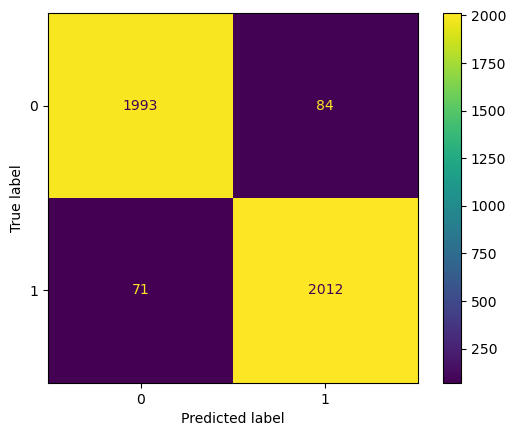

In [70]:
sag = LogisticRegression(solver='sag')

SAG = get_evaluation_result(sag, X_train, X_test, y_train, y_test)

In [71]:
SAG

LogisticRegression(solver='sag')

# 5. Random Forest Logistic Regression

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.98
Accuracy: 0.9331730769230769
Precision: 0.9678589942975635
Recall: 0.8963034085453673
F1 Score: 0.9307078763708873
Matthews Correlation Coefficient: 0.8687440132279416
Cohen's Kappa: 0.8663601467394432
AUC-ROC: 0.9332263311383553
classification_report: 
              precision    recall  f1-score   support

           0       0.90      0.97      0.94      2077
           1       0.97      0.90      0.93      2083

    accuracy                           0.93      4160
   macro avg       0.94      0.93      0.93      4160
weighted avg       0.94      0.93      0.93      4160



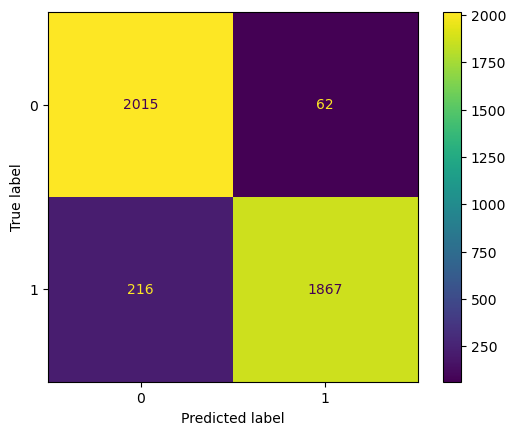

In [72]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

RF = get_evaluation_result(rf, X_train, X_test, y_train, y_test)

In [73]:
RF

RandomForestClassifier(random_state=42)

# 6. Perceptron

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.98
Accuracy: 0.9668269230769231
Precision: 0.964200477326969
Recall: 0.9697551608257321
F1 Score: 0.9669698420296793
Matthews Correlation Coefficient: 0.9336686946412479
Cohen's Kappa: 0.933653156063245
AUC-ROC: 0.9668226935568236
classification_report: 
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      2077
           1       0.96      0.97      0.97      2083

    accuracy                           0.97      4160
   macro avg       0.97      0.97      0.97      4160
weighted avg       0.97      0.97      0.97      4160



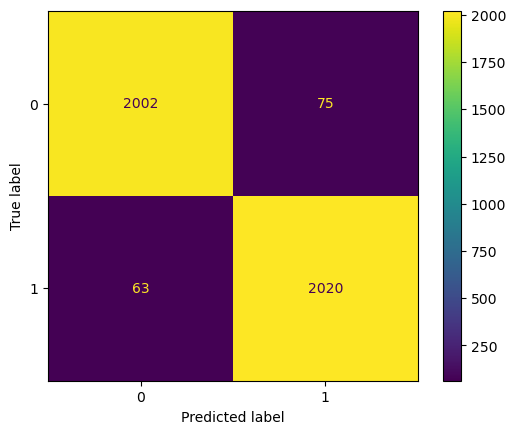

In [74]:
from sklearn.linear_model import Perceptron

perceptron = Perceptron(max_iter=1000, eta0=0.1, random_state=0)
PERCEPTON = get_evaluation_result(perceptron, X_train, X_test, y_train, y_test)

In [75]:
PERCEPTON

Perceptron(eta0=0.1)

# 7. RidgeClassifier

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.98
Accuracy: 0.9776442307692308
Precision: 0.9756214149139579
Recall: 0.9798367738838214
F1 Score: 0.9777245508982036
Matthews Correlation Coefficient: 0.9552970323423648
Cohen's Kappa: 0.9552880894903896
AUC-ROC: 0.9776410638798019
classification_report: 
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2077
           1       0.98      0.98      0.98      2083

    accuracy                           0.98      4160
   macro avg       0.98      0.98      0.98      4160
weighted avg       0.98      0.98      0.98      4160



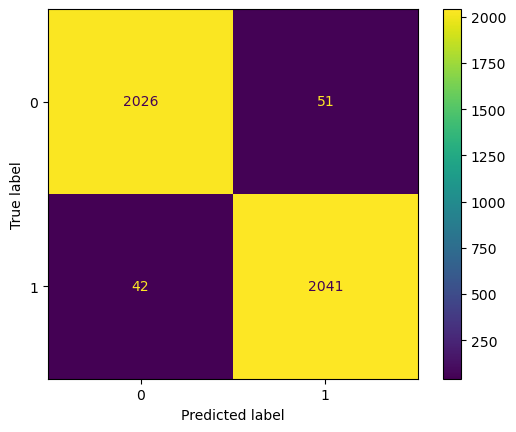

In [76]:
from sklearn.linear_model import RidgeClassifier
ridge_classifier = RidgeClassifier(alpha=1.0, solver='auto', random_state=0)
RIDGE = get_evaluation_result(ridge_classifier, X_train, X_test, y_train, y_test)

In [77]:
RIDGE

RidgeClassifier(random_state=0)

# 8. CatBoostClassifier

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.98
Accuracy: 0.973798076923077
Precision: 0.9717973231357553
Recall: 0.9759961593855017
F1 Score: 0.9738922155688622
Matthews Correlation Coefficient: 0.947604588630273
Cohen's Kappa: 0.9475957177898114
AUC-ROC: 0.9737949020326641
classification_report: 
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      2077
           1       0.97      0.98      0.97      2083

    accuracy                           0.97      4160
   macro avg       0.97      0.97      0.97      4160
weighted avg       0.97      0.97      0.97      4160



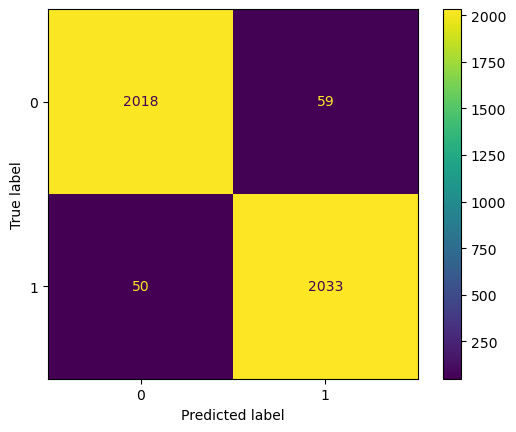

In [78]:
from catboost import CatBoostClassifier
# Create a CatBoostClassifier instance with specified hyperparameters
catboost_classifier = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, loss_function='Logloss', verbose=0)

CAT = get_evaluation_result(catboost_classifier, X_train, X_test, y_train, y_test)

In [79]:
CAT

# 9. NearestCentroidClassifier

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.98
Accuracy: 0.8463942307692308
Precision: 0.7874203821656051
Recall: 0.9495919347095535
F1 Score: 0.8609357997823721
Matthews Correlation Coefficient: 0.7079265253370388
Cohen's Kappa: 0.6926964068378472
AUC-ROC: 0.8462451729397551
classification_report: 
              precision    recall  f1-score   support

           0       0.94      0.74      0.83      2077
           1       0.79      0.95      0.86      2083

    accuracy                           0.85      4160
   macro avg       0.86      0.85      0.84      4160
weighted avg       0.86      0.85      0.84      4160



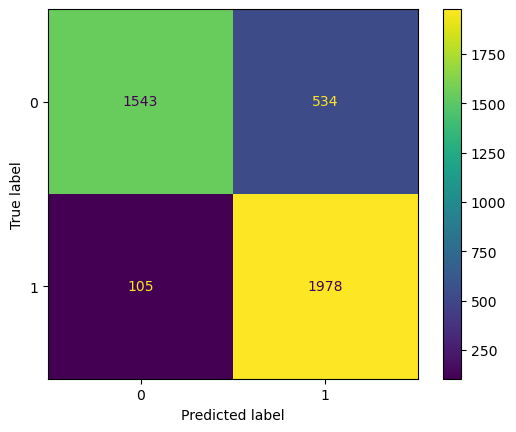

In [80]:
from sklearn.neighbors import NearestCentroid
ncc = NearestCentroid()

NEARESTCENTROID = get_evaluation_result(ncc, X_train, X_test, y_train, y_test)

In [81]:
NEARESTCENTROID

NearestCentroid()

# 10. Stochastic Gradient Descent (SGDClassifier)

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.98
Accuracy: 0.9752403846153846
Precision: 0.9745925215723873
Recall: 0.9759961593855017
F1 Score: 0.9752938354521468
Matthews Correlation Coefficient: 0.9504815518340736
Cohen's Kappa: 0.950480563205006
AUC-ROC: 0.9752392929811475
classification_report: 
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      2077
           1       0.97      0.98      0.98      2083

    accuracy                           0.98      4160
   macro avg       0.98      0.98      0.98      4160
weighted avg       0.98      0.98      0.98      4160



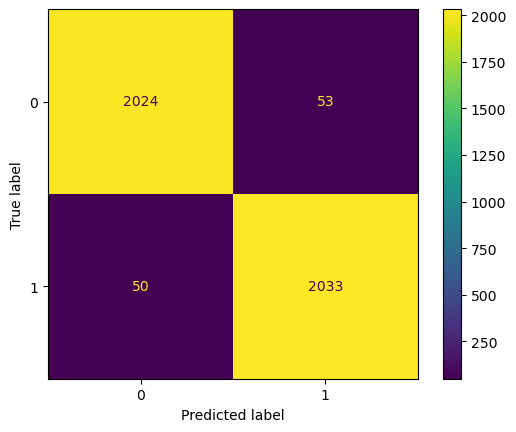

In [82]:
from sklearn.linear_model import SGDClassifier
sgd_classifier = SGDClassifier()

SGD = get_evaluation_result(sgd_classifier, X_train, X_test, y_train, y_test)

In [83]:
SGD

SGDClassifier()

# 11. SVC (kernel=”linear”, C=0.025):

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.98
Accuracy: 0.9016826923076923
Precision: 0.8552631578947368
Recall: 0.9673547767642823
F1 Score: 0.9078621311106104
Matthews Correlation Coefficient: 0.8103404515064567
Cohen's Kappa: 0.8033277448624135
AUC-ROC: 0.9015878361433352
classification_report: 
              precision    recall  f1-score   support

           0       0.96      0.84      0.89      2077
           1       0.86      0.97      0.91      2083

    accuracy                           0.90      4160
   macro avg       0.91      0.90      0.90      4160
weighted avg       0.91      0.90      0.90      4160



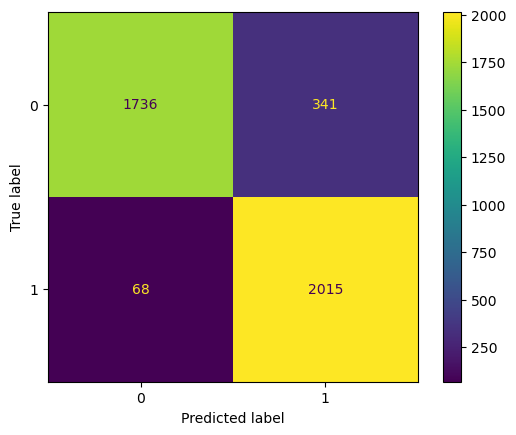

In [84]:
from sklearn.svm import SVC
svm_lin = SVC(kernel="linear", C=0.025)

SVC_LINEAR  = get_evaluation_result(svm_lin, X_train, X_test, y_train, y_test)

In [85]:
SVC_LINEAR

SVC(C=0.025, kernel='linear')

# 12. SVC (gama=2, C=1)

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.98
Accuracy: 0.9610576923076923
Precision: 0.9549976314542871
Recall: 0.9678348535765723
F1 Score: 0.9613733905579399
Matthews Correlation Coefficient: 0.9221972748310363
Cohen's Kappa: 0.9221137103770028
AUC-ROC: 0.9610479034372992
classification_report: 
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      2077
           1       0.95      0.97      0.96      2083

    accuracy                           0.96      4160
   macro avg       0.96      0.96      0.96      4160
weighted avg       0.96      0.96      0.96      4160



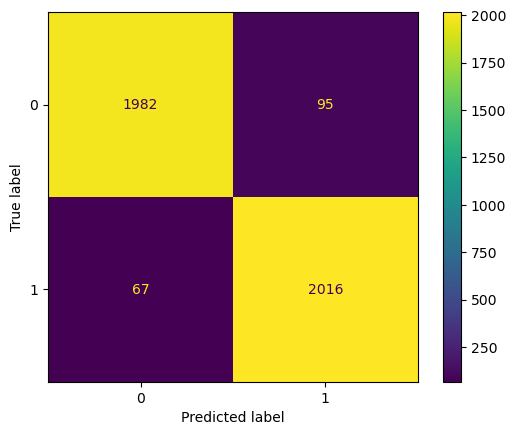

In [86]:
svm_rbf = SVC(kernel="rbf", gamma=2, C=1)

SVC_GAMA = get_evaluation_result(svm_rbf, X_train, X_test, y_train, y_test)

In [87]:
SVC_GAMA

SVC(C=1, gamma=2)

# 13. LinearSVC

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.98
Accuracy: 0.9771634615384616
Precision: 0.9769673704414588
Recall: 0.9774363898223716
F1 Score: 0.9772018238540917
Matthews Correlation Coefficient: 0.9543269066863176
Cohen's Kappa: 0.9543267963945906
AUC-ROC: 0.9771630673233187
classification_report: 
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2077
           1       0.98      0.98      0.98      2083

    accuracy                           0.98      4160
   macro avg       0.98      0.98      0.98      4160
weighted avg       0.98      0.98      0.98      4160



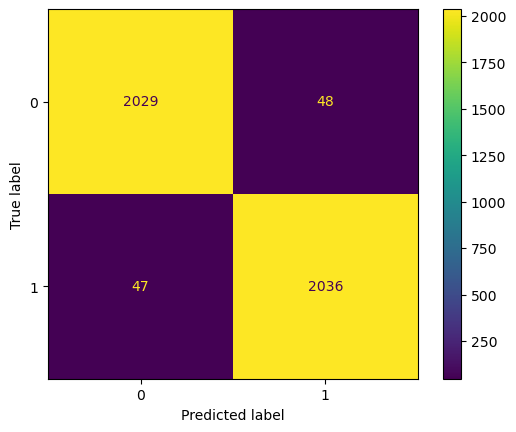

In [88]:
from sklearn.svm import LinearSVC
linear_svm_classifier = LinearSVC(C=1.0, random_state=0)

LINEARSVC = get_evaluation_result(linear_svm_classifier, X_train, X_test, y_train, y_test)

In [89]:
LINEARSVC

LinearSVC(random_state=0)

# 14. SDGClassifier

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.98
Accuracy: 0.9759615384615384
Precision: 0.9773712084737602
Recall: 0.9745559289486317
F1 Score: 0.9759615384615383
Matthews Correlation Coefficient: 0.951927137422392
Cohen's Kappa: 0.9519231769349592
AUC-ROC: 0.975963568711196
classification_report: 
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      2077
           1       0.98      0.97      0.98      2083

    accuracy                           0.98      4160
   macro avg       0.98      0.98      0.98      4160
weighted avg       0.98      0.98      0.98      4160



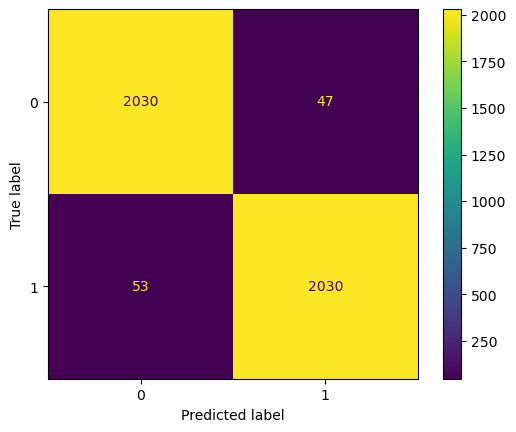

In [39]:
from sklearn.linear_model import SGDClassifier
# Create an SGDClassifier instance with hinge loss (SVM-like behavior), L2 regularization, and an initial learning rate (eta0)
sgd_classifier = SGDClassifier(loss='hinge', penalty='l2', alpha=0.0001, eta0=0.01, random_state=0, max_iter=1000)

get_evaluation_result(sgd_classifier, X_train, X_test, y_train, y_test)

# 15. ZeroR

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.98
Accuracy: 0.5007211538461539
Precision: 0.5007211538461539
Recall: 1.0
F1 Score: 0.6673073842703828
Matthews Correlation Coefficient: 0.0
Cohen's Kappa: 0.0
AUC-ROC: 0.5
classification_report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2077
           1       0.50      1.00      0.67      2083

    accuracy                           0.50      4160
   macro avg       0.25      0.50      0.33      4160
weighted avg       0.25      0.50      0.33      4160



C:\Users\Dac\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dac\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dac\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


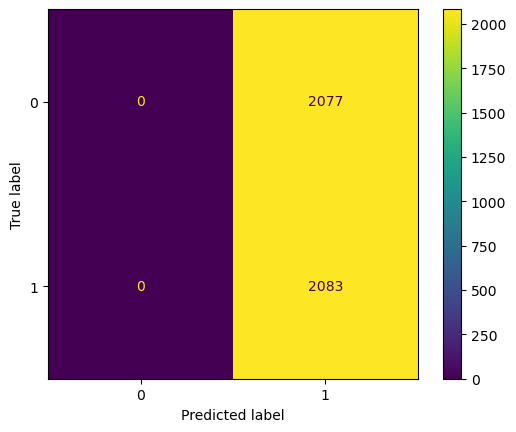

In [90]:
from sklearn.dummy import DummyClassifier

# Create a ZeroR classifier
zeror_model = DummyClassifier(strategy="most_frequent")

ZEROR = get_evaluation_result(zeror_model, X_train, X_test, y_train, y_test)

In [91]:
ZEROR

DummyClassifier(strategy='most_frequent')

# 16. DecisionTreeClassifier

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.98
Accuracy: 0.9596153846153846
Precision: 0.9614457831325302
Recall: 0.957753240518483
F1 Score: 0.9595959595959597
Matthews Correlation Coefficient: 0.9192378483381612
Cohen's Kappa: 0.9192310492636513
AUC-ROC: 0.959618074279463
classification_report: 
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2077
           1       0.96      0.96      0.96      2083

    accuracy                           0.96      4160
   macro avg       0.96      0.96      0.96      4160
weighted avg       0.96      0.96      0.96      4160



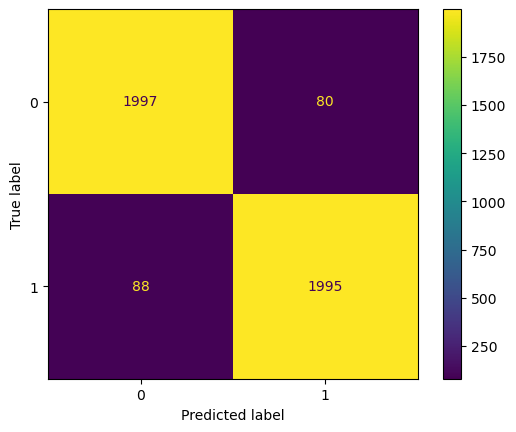

In [92]:
from sklearn.tree import DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier(max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=0)

DT = get_evaluation_result(dt_classifier, X_train, X_test, y_train, y_test)

In [93]:
DT

DecisionTreeClassifier(random_state=0)

# 17.Passive Aggressive (PassiveAggressiveClassifier)

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.98
Accuracy: 0.9762019230769231
Precision: 0.9778420038535646
Recall: 0.9745559289486317
F1 Score: 0.9761962010098582
Matthews Correlation Coefficient: 0.9524093715603025
Cohen's Kappa: 0.9524039781694392
AUC-ROC: 0.9762043005359433
classification_report: 
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      2077
           1       0.98      0.97      0.98      2083

    accuracy                           0.98      4160
   macro avg       0.98      0.98      0.98      4160
weighted avg       0.98      0.98      0.98      4160



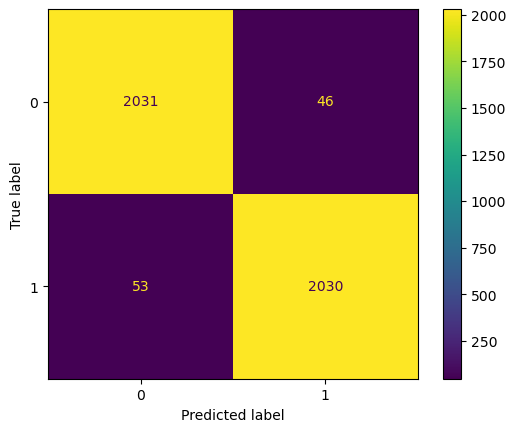

In [94]:
from sklearn.linear_model import PassiveAggressiveClassifier
pa_classifier = PassiveAggressiveClassifier(C=1.0, random_state=0, max_iter=1000)

PA = get_evaluation_result(pa_classifier, X_train, X_test, y_train, y_test)

In [100]:
PA

PassiveAggressiveClassifier(random_state=0)

# 18.ExtraTreeClassifier

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.98
Accuracy: 0.9276442307692307
Precision: 0.9816216216216216
Recall: 0.8718194911185789
F1 Score: 0.9234680905161454
Matthews Correlation Coefficient: 0.860727187619484
Cohen's Kappa: 0.855311537314916
AUC-ROC: 0.9277248635178836
classification_report: 
              precision    recall  f1-score   support

           0       0.88      0.98      0.93      2077
           1       0.98      0.87      0.92      2083

    accuracy                           0.93      4160
   macro avg       0.93      0.93      0.93      4160
weighted avg       0.93      0.93      0.93      4160



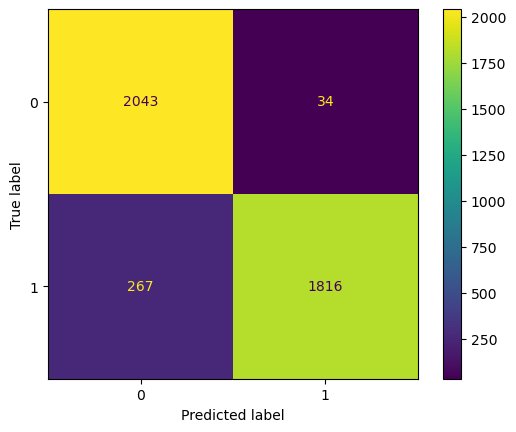

In [95]:
from sklearn.ensemble import ExtraTreesClassifier
extra_tree_classifier = ExtraTreesClassifier(n_estimators=100, random_state=0)

EXTRATREE = get_evaluation_result(extra_tree_classifier, X_train, X_test, y_train, y_test)

In [96]:
EXTRATREE

ExtraTreesClassifier(random_state=0)

# 19.Random Patches

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.98
Accuracy: 0.9728365384615385
Precision: 0.98095703125
Recall: 0.9644743158905424
F1 Score: 0.9726458484628419
Matthews Correlation Coefficient: 0.9458081865024708
Cohen's Kappa: 0.9456742823753911
AUC-ROC: 0.9728486167801291
classification_report: 
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2077
           1       0.98      0.96      0.97      2083

    accuracy                           0.97      4160
   macro avg       0.97      0.97      0.97      4160
weighted avg       0.97      0.97      0.97      4160



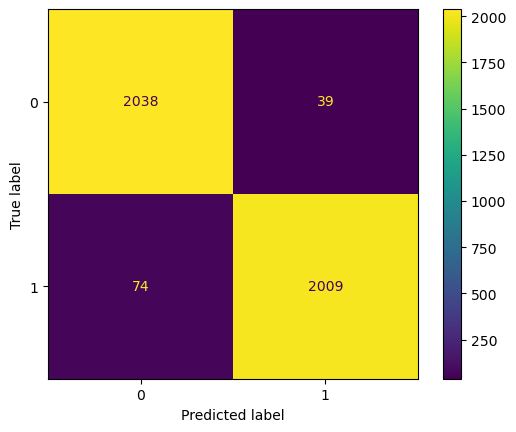

In [97]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Create a base learner (e.g., Decision Tree)
base_learner = DecisionTreeClassifier()

# Create a BaggingClassifier with Random Patches
bagging = BaggingClassifier(base_learner, max_samples=0.8, max_features=0.8, n_estimators=10, random_state=42)

RANDOMPATCHES = get_evaluation_result(bagging, X_train, X_test, y_train, y_test)

In [98]:
RANDOMPATCHES

BaggingClassifier(estimator=DecisionTreeClassifier(), max_features=0.8,
                  max_samples=0.8, random_state=42)

# 20.VotingClassifier

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.98
Accuracy: 0.9788461538461538
Precision: 0.9863481228668942
Recall: 0.971195391262602
F1 Score: 0.9787131107885825
Matthews Correlation Coefficient: 0.9578065104763693
Cohen's Kappa: 0.957693158444715
AUC-ROC: 0.9788572045383787
classification_report: 
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2077
           1       0.99      0.97      0.98      2083

    accuracy                           0.98      4160
   macro avg       0.98      0.98      0.98      4160
weighted avg       0.98      0.98      0.98      4160



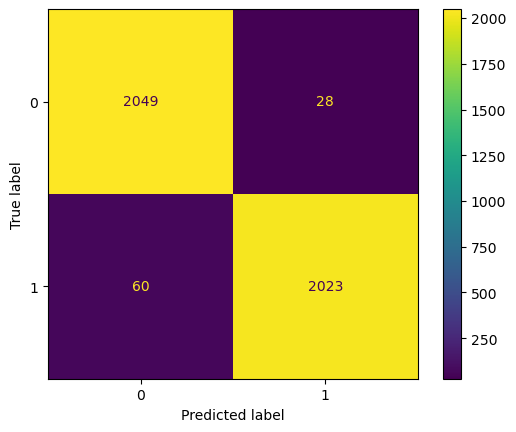

In [120]:
from sklearn.ensemble import VotingClassifier

# Define individual classifiers
classifier1 = DecisionTreeClassifier()
classifier2 = SVC(probability=True)  # Use probability=True for soft voting
classifier3 = RandomForestClassifier()

# Create a VotingClassifier instance with soft voting
voting_classifier = VotingClassifier(estimators=[
    ('decision_tree', classifier1),
    ('svm', classifier2),
    ('random_forest', classifier3)
], voting='soft')  # You can also use 'hard' for hard voting

VOTING = get_evaluation_result(voting_classifier, X_train, X_test, y_train, y_test)

In [121]:
VOTING

VotingClassifier(estimators=[('decision_tree', DecisionTreeClassifier()),
                             ('svm', SVC(probability=True)),
                             ('random_forest', RandomForestClassifier())],
                 voting='soft')

# 21. Stacked_generalization

In [122]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Define base models
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=0)),
    ('svc', SVC(probability=True)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=0))
]

# Define the meta-model
meta_model = LogisticRegression()

# Create a StackingClassifier instance
stacked_model = StackingClassifier(estimators=base_models, final_estimator=meta_model)

STACKGEN = get_evaluation_result(stacked_model, X_train, X_test, y_train, y_test)

KeyboardInterrupt: 

In [ ]:
STACKGEN

# 22.MLPClassifier:

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.98
Accuracy: 0.9764423076923077
Precision: 0.9810954920019389
Recall: 0.971675468074892
F1 Score: 0.9763627592860589
Matthews Correlation Coefficient: 0.9529292225898623
Cohen's Kappa: 0.9528851707785434
AUC-ROC: 0.9764491928723039
classification_report: 
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      2077
           1       0.98      0.97      0.98      2083

    accuracy                           0.98      4160
   macro avg       0.98      0.98      0.98      4160
weighted avg       0.98      0.98      0.98      4160



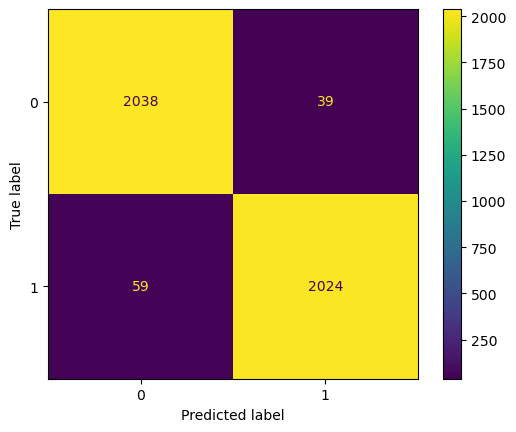

In [101]:
from sklearn.neural_network import MLPClassifier

# Create an MLPClassifier instance with specified architecture and hyperparameters
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', max_iter=1000, random_state=0)

MLP = get_evaluation_result(mlp_classifier, X_train, X_test, y_train, y_test)

In [102]:
MLP

MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=0)

# 23.BernoulliRBM:

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.98
Accuracy: 0.9774038461538461
Precision: 0.9769784172661871
Recall: 0.9779164666346616
F1 Score: 0.977447216890595
Matthews Correlation Coefficient: 0.9548079770115272
Cohen's Kappa: 0.9548075356215409
AUC-ROC: 0.9774031057294635
classification_report: 
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2077
           1       0.98      0.98      0.98      2083

    accuracy                           0.98      4160
   macro avg       0.98      0.98      0.98      4160
weighted avg       0.98      0.98      0.98      4160



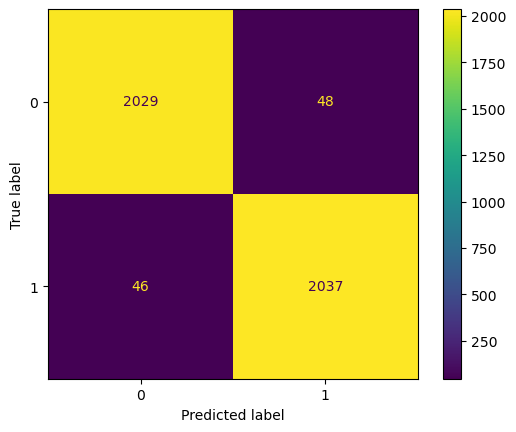

In [103]:
import lightgbm as lgb
lgb_classifier = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=31, learning_rate=0.05, n_estimators=100)

BERNOULLIRBM = get_evaluation_result(lgb_classifier, X_train, X_test, y_train, y_test)

In [104]:
BERNOULLIRBM

LGBMClassifier(learning_rate=0.05)

# 24.AdaBoostClassifier

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.98
Accuracy: 0.9634615384615385
Precision: 0.9595430747263208
Recall: 0.9678348535765723
F1 Score: 0.9636711281070746
Matthews Correlation Coefficient: 0.9269567238954554
Cohen's Kappa: 0.9269220127789398
AUC-ROC: 0.9634552216847715
classification_report: 
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      2077
           1       0.96      0.97      0.96      2083

    accuracy                           0.96      4160
   macro avg       0.96      0.96      0.96      4160
weighted avg       0.96      0.96      0.96      4160



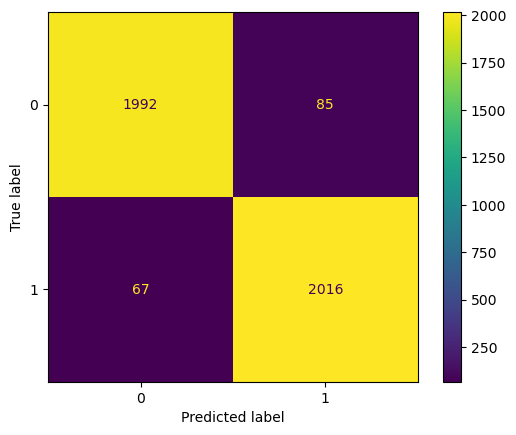

In [105]:
from sklearn.ensemble import AdaBoostClassifier

adaboost_classifier = AdaBoostClassifier(n_estimators=50, learning_rate=1.0, random_state=0)

ADA = get_evaluation_result(adaboost_classifier, X_train, X_test, y_train, y_test)

In [106]:
ADA

AdaBoostClassifier(random_state=0)

# 25.GradientBoostingClassifier

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.98
Accuracy: 0.9673076923076923
Precision: 0.9655667144906743
Recall: 0.9692750840134422
F1 Score: 0.9674173454719692
Matthews Correlation Coefficient: 0.9346217988987761
Cohen's Kappa: 0.9346148858846233
AUC-ROC: 0.9673048506249204
classification_report: 
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2077
           1       0.97      0.97      0.97      2083

    accuracy                           0.97      4160
   macro avg       0.97      0.97      0.97      4160
weighted avg       0.97      0.97      0.97      4160



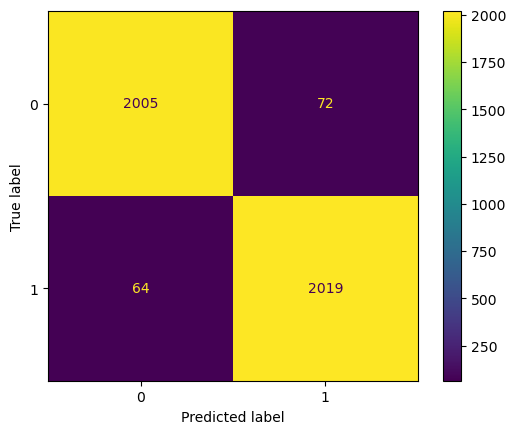

In [107]:
from sklearn.ensemble import GradientBoostingClassifier
gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0)

GRADIENTB = get_evaluation_result(gb_classifier, X_train, X_test, y_train, y_test)

In [108]:
GRADIENTB

GradientBoostingClassifier(random_state=0)

# 26.Ordinal Learning Model

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.98
Accuracy: 0.9627403846153846
Precision: 0.9599236641221374
Recall: 0.9659145463274124
F1 Score: 0.96290978703039
Matthews Correlation Coefficient: 0.9254980191658101
Cohen's Kappa: 0.9254799424549829
AUC-ROC: 0.9627357998849387
classification_report: 
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      2077
           1       0.96      0.97      0.96      2083

    accuracy                           0.96      4160
   macro avg       0.96      0.96      0.96      4160
weighted avg       0.96      0.96      0.96      4160



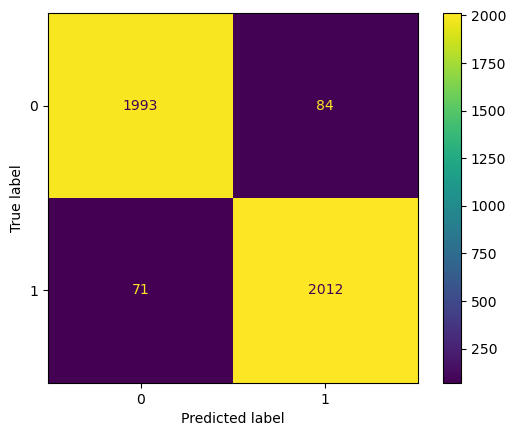

In [109]:
from mord import LogisticAT

# Create and train an Ordinal Logistic Regression model (LogisticAT)
ordinal_classifier = LogisticAT(alpha=1.0)  # You can adjust the regularization parameter alpha

OLM = get_evaluation_result(ordinal_classifier, X_train, X_test, y_train, y_test)

In [110]:
OLM

LogisticAT()

# 27.Xgboost

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.98
Accuracy: 0.9670673076923076
Precision: 0.9637750238322211
Recall: 0.970715314450312
F1 Score: 0.9672327194451088
Matthews Correlation Coefficient: 0.9341580852439406
Cohen's Kappa: 0.9341337932749716
AUC-ROC: 0.9670620385443663
classification_report: 
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      2077
           1       0.96      0.97      0.97      2083

    accuracy                           0.97      4160
   macro avg       0.97      0.97      0.97      4160
weighted avg       0.97      0.97      0.97      4160



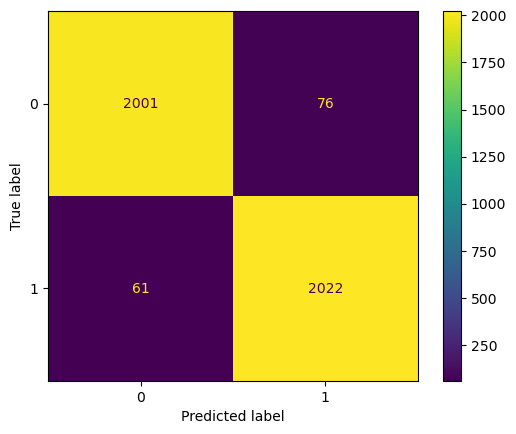

In [111]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Create an XGBClassifier instance with specified hyperparameters
xgb_classifier = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0)

XGB = get_evaluation_result(xgb_classifier, X_train, X_test, y_train, y_test)

In [112]:
XGB

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)

# 28.Decision Stump

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.98
Accuracy: 0.7745192307692308
Precision: 0.7242459851155504
Recall: 0.8876620259241479
F1 Score: 0.7976704055220019
Matthews Correlation Coefficient: 0.5634737543126456
Cohen's Kappa: 0.5488905037964329
AUC-ROC: 0.774355808340023
classification_report: 
              precision    recall  f1-score   support

           0       0.85      0.66      0.75      2077
           1       0.72      0.89      0.80      2083

    accuracy                           0.77      4160
   macro avg       0.79      0.77      0.77      4160
weighted avg       0.79      0.77      0.77      4160



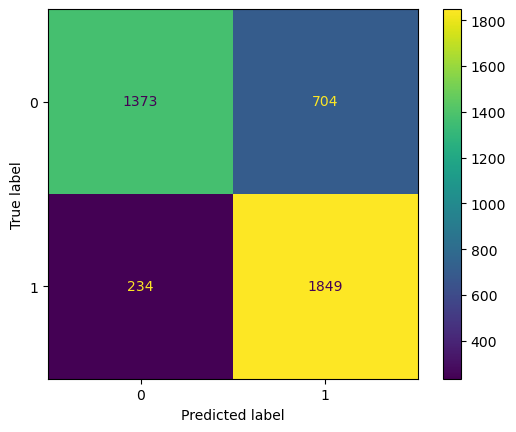

In [113]:
from sklearn.tree import DecisionTreeClassifier

# Create and train a Decision Stump (a DecisionTreeClassifier with max_depth=1)
decision_stump = DecisionTreeClassifier(max_depth=1)

DECISIONSTUMP = get_evaluation_result(decision_stump, X_train, X_test, y_train, y_test)

In [114]:
DECISIONSTUMP

DecisionTreeClassifier(max_depth=1)

# 29.ComplementNB

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.98
Accuracy: 0.8536057692307693
Precision: 0.9959623149394348
Recall: 0.7105136821891502
F1 Score: 0.8293639674978986
Matthews Correlation Coefficient: 0.7383731296418452
Cohen's Kappa: 0.7073320853882761
AUC-ROC: 0.8538124501460918
classification_report: 
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      2077
           1       1.00      0.71      0.83      2083

    accuracy                           0.85      4160
   macro avg       0.89      0.85      0.85      4160
weighted avg       0.89      0.85      0.85      4160



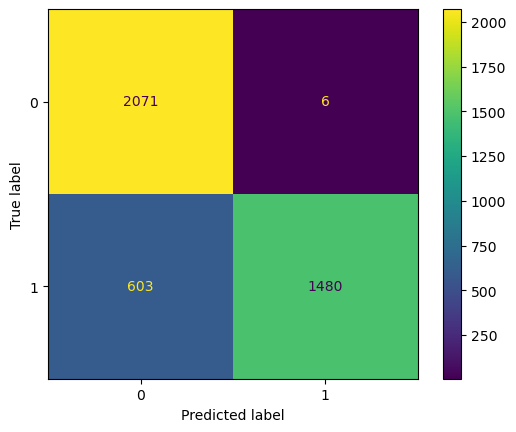

In [115]:
from sklearn.naive_bayes import ComplementNB

# Create a ComplementNB instance
complement_nb_classifier = ComplementNB()
COMPLEMENTNB = get_evaluation_result(complement_nb_classifier, X_train, X_test, y_train, y_test)

In [116]:
COMPLEMENTNB

ComplementNB()

# 30.MultinomialNB

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.98
Accuracy: 0.854326923076923
Precision: 0.9959704499664204
Recall: 0.7119539126260201
F1 Score: 0.8303471444568868
Matthews Correlation Coefficient: 0.7395451941775948
Cohen's Kappa: 0.7087731936777943
AUC-ROC: 0.8545325653645267
classification_report: 
              precision    recall  f1-score   support

           0       0.78      1.00      0.87      2077
           1       1.00      0.71      0.83      2083

    accuracy                           0.85      4160
   macro avg       0.89      0.85      0.85      4160
weighted avg       0.89      0.85      0.85      4160



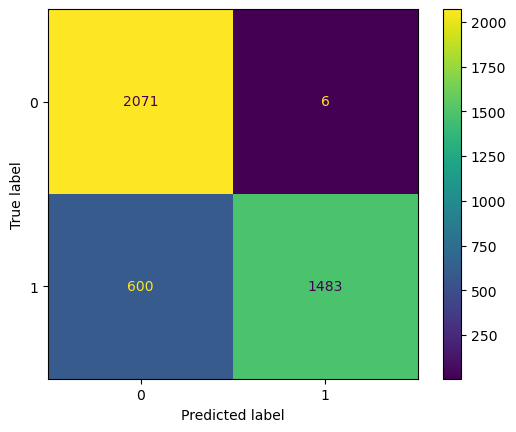

In [117]:
from sklearn.naive_bayes import MultinomialNB

# Create a MultinomialNB instance
multinomial_nb_classifier = MultinomialNB()
MULTINOMIALNB = get_evaluation_result(multinomial_nb_classifier, X_train, X_test, y_train, y_test)

In [118]:
MULTINOMIALNB

MultinomialNB()

In [123]:
def wordopt(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)    
    return text

# FAKE NEWS DETECTION SIMULATION

In [124]:
#vectorization = TfidfVectorizer()

def output_lable(n):
    if n == 1:
        return "Fake News"
    elif n == 0:
        return "Not A Fake News"
    
def manual_testing(news):
    testing_news = {"text":[news]}
    new_def_test = pd.DataFrame(testing_news)
    new_def_test["text"] = new_def_test["text"].apply(wordopt) 
    new_x_test = new_def_test["text"]
    #new_xv_test = tf_idf_matrix.transform(new_x_test)
    #pred_LR = LGFG.predict(new_xv_test)
    new_xv_test = count_vectorizer.transform(new_x_test)
    new_xv_test = tfidf.transform(new_xv_test)
    #=========================================
    pred_LGFG = LGFG.predict(new_xv_test)
    pred_LIBLINEAR = LIBLINEAR.predict(new_xv_test)
    pred_NEWTON = NEWTON.predict(new_xv_test)
    pred_SAG = SAG.predict(new_xv_test)
    pred_RF = RF.predict(new_xv_test)
    pred_PERCEPTON = PERCEPTON.predict(new_xv_test)
    pred_RIDGE = RIDGE.predict(new_xv_test)
    pred_CAT = CAT.predict(new_xv_test)
    pred_NEARESTCENTROID = NEARESTCENTROID.predict(new_xv_test)
    pred_SGD = SGD.predict(new_xv_test)
    pred_SVC_LINEAR = SVC_LINEAR.predict(new_xv_test)
    pred_SVC_GAMA = SVC_GAMA.predict(new_xv_test)
    pred_LINEARSVC = LINEARSVC.predict(new_xv_test)
    pred_ZEROR = ZEROR.predict(new_xv_test)
    pred_DT = DT.predict(new_xv_test)
    pred_PA = PA.predict(new_xv_test)
    pred_EXTRATREE = EXTRATREE.predict(new_xv_test)
    pred_RANDOMPATCHES = RANDOMPATCHES.predict(new_xv_test)
    pred_VOTING = VOTING.predict(new_xv_test)
    #pred_STACKGEN = STACKGEN.predict(new_xv_test)
    pred_MLP = MLP.predict(new_xv_test)
    pred_BERNOULLIRBM = BERNOULLIRBM.predict(new_xv_test)
    pred_ADA = ADA.predict(new_xv_test)
    pred_GRADIENTB = GRADIENTB.predict(new_xv_test)
    pred_OLM = OLM.predict(new_xv_test)
    pred_XGB = XGB.predict(new_xv_test)
    pred_DECISIONSTUMP = DECISIONSTUMP.predict(new_xv_test)
    pred_COMPLEMENTNB = COMPLEMENTNB.predict(new_xv_test)
    pred_MULTINOMIALNB = MULTINOMIALNB.predict(new_xv_test)
    return print("\n\nlbfgs Prediction: {} \nliblinear Prediction: {} \nnewton-cg Prediction: {} \nSag Prediction: {} \nRandomForest Prediction: {} \nPerceptron Prediction: {} \nRidgeClassifier Prediction: {} \nCatBoost Prediction: {} \nNearest Centroid Prediction: {}\nSGD Prediction: {} \nSVC-linear Prediction: {} \nSVC-gama Prediction: {} \nLinearSVC Prediction: {} \nZero Prediction: {} \nDecision Tree Prediction: {} \nPassive Aggressive Prediction: {} \nExtra Tree Prediction: {} \nRandom Patches Prediction: {} \nVoting Prediction: {} \nMLP Prediction: {} \nBernoulliRBM Prediction: {} \nAdaBoost Prediction: {} \nGradientBoosting Prediction: {} \nOLM Prediction: {} \nXGBoost Prediction: {} \nDecision Stump Prediction: {} \nComplementNB Prediction: {} \nMultinomialNB Prediction: {}".format(output_lable(pred_LGFG[0]),
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       output_lable(pred_LIBLINEAR[0]),
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       output_lable(pred_LGFG[0]),
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       output_lable(pred_NEWTON[0]),
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       output_lable(pred_SAG[0]),
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       output_lable(pred_RF[0]),
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       output_lable(pred_PERCEPTON[0]),
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       output_lable(pred_RIDGE[0]),
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       output_lable(pred_CAT[0]),
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       output_lable(pred_NEARESTCENTROID[0]),
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       output_lable(pred_SGD[0]),
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       output_lable(pred_SVC_LINEAR[0]),
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       output_lable(pred_SVC_GAMA[0]),
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       output_lable(pred_LINEARSVC[0]),
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       output_lable(pred_ZEROR[0]),
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       output_lable(pred_DT[0]),
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       output_lable(pred_PA[0]),
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       output_lable(pred_EXTRATREE[0]),
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       output_lable(pred_RANDOMPATCHES[0]),
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       output_lable(pred_VOTING[0]),
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       output_lable(pred_MLP[0]),
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       output_lable(pred_BERNOULLIRBM[0]),
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       output_lable(pred_ADA[0]),
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       output_lable(pred_GRADIENTB[0]),
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       output_lable(pred_OLM[0]),
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       output_lable(pred_XGB[0]),
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       output_lable(pred_DECISIONSTUMP[0]),
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       output_lable(pred_COMPLEMENTNB[0]),
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       output_lable(pred_MULTINOMIALNB[0])))

In [ ]:
title = str(input("Please Enter news title: \n"))
author = str(input("Please Enter news author: \n"))
text =  str(input("Please Enter news content: \n"))
news = title + ' ' + author + ' ' + ' ' + text
manual_testing(news)

Please Enter news title: 
House Dem Aide: We Didnâ€™t Even See Comeyâ€™s Letter Until Jason Chaffetz Tweeted It
Please Enter news author: 
Darrell Lucus
